In [1]:
# import libraries  
import argparse
from collections import Counter, defaultdict
import cv2
from PIL import Image
import glob
import geopy
from geopy.distance import distance
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd
import pickle

import rasterio
import shapely
from shapely.geometry import Point, Polygon
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import transform as sktransform
import math
import random
from statistics import mean

# CVRPLIB (Uchoa & Al.)

In [2]:
NLKH_log_folder = "cvrplib/NeuroLKH_log/*.log"
LKH_log_folder = "cvrplib/LKH_log/*.log"

In [3]:
neuro_log_file = glob.glob(NLKH_log_folder)
lkh_log_file = glob.glob(LKH_log_folder)

In [5]:
is_opt = ['no','no','no','yes','yes','no','yes','no','no','no','no','no','yes','no','no','no','yes','no','no','no',
         'no','no','no','yes','no','no','no','no','no','no','no','no','no','no','no','no','yes','no','no','no','no']
len(is_opt)

41

In [6]:
cvrplib_df = pd.DataFrame(columns = ['Instance Name', 'BKS','Optimal Solution','LKH Solution',
                                     'LKH BKS Gap [%] ','LKH Solving Time [s] ','NeuroLKH Solution','NeuroLKH BKS Gap [%]','NeuroLKH Solving Time [s] ',
                                     'Gap Difference [%]','Solving Time Difference [s]','Time Ratio'])

In [7]:
cvrplib_df

,Instance Name,BKS,Optimal Solution,LKH Solution,LKH BKS Gap [%],LKH Solving Time [s],NeuroLKH Solution,NeuroLKH BKS Gap [%],NeuroLKH Solving Time [s],Gap Difference [%],Solving Time Difference [s],Time Ratio


In [8]:
ratio_time_var = [] 
diff_time_var = []
for i in range(len(neuro_log_file)):
    with open(neuro_log_file[i], 'r') as f:
        neuro_log_data = f.readlines()
    
    line_ = []
    for line in neuro_log_data:
        line = line.split()
        line_.append(line)
        
    while([] in line_):
        line_.remove([])
        
    with open(lkh_log_file[i], 'r') as f:
        lkh_log_data = f.readlines()
    
    line_lkh_ = []
    for line in lkh_log_data:
        line = line.split()
        line_lkh_.append(line)
    
    while([] in line_lkh_):
        line_lkh_.remove([])
    is_opt_i = is_opt[i]
    name = line_[0][-1][29:-5]
    bks = line_[35][-1]
    NeuroLKH_sol = line_[-11][-1]
    opt_gap_nlkh = line_[-10][-1][:-1]
    NeuroLKH_time = line_[-7][-2]
    LKH_sol = line_lkh_[-11][-1]
    opt_gap_lkh = line_lkh_[-10][-1][:-1]
    opt_gap_diff = str(round(float(opt_gap_lkh) - float(opt_gap_nlkh),2))
    LKH_time = line_lkh_[-7][-2]
    diff_time = str(round(float(LKH_time) - float(NeuroLKH_time),2))
    diff_time_var.append(round(float(LKH_time) - float(NeuroLKH_time),2))
    ratio_time = str(round(float(LKH_time)/float(NeuroLKH_time),2))
    ratio_time_var.append(round(float(LKH_time)/float(NeuroLKH_time),2))
    cvrplib_df = cvrplib_df.append({'Instance Name': name, 'BKS' : bks , 'Optimal Solution' : is_opt_i, 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
                               'NeuroLKH Solution' : NeuroLKH_sol , 'NeuroLKH BKS Gap [%]' : opt_gap_nlkh , 'NeuroLKH Solving Time [s] ' : NeuroLKH_time ,
                                     'Gap Difference [%]' : opt_gap_diff,'Solving Time Difference [s]' : diff_time, 'Time Ratio' : ratio_time}, ignore_index=True)


C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\804510228.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cvrplib_df = cvrplib_df.append({'Instance Name': name, 'BKS' : bks , 'Optimal Solution' : is_opt_i, 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\804510228.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cvrplib_df = cvrplib_df.append({'Instance Name': name, 'BKS' : bks , 'Optimal Solution' : is_opt_i, 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\804510228.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

In [10]:
cvrplib_df.to_csv('cvrplib_results.csv', index=False)


In [11]:
ratio_var = []
gap_diff_var = []
mean_gap_lkh = []
mean_gap_nlkh = []
for i in range(len(neuro_log_file)):
    ratio_var.append(float(cvrplib_df["Time Ratio"].loc[i]))
    mean_gap_lkh.append(float(cvrplib_df["LKH BKS Gap [%] "].loc[i]))
    mean_gap_nlkh.append(float(cvrplib_df["NeuroLKH BKS Gap [%]"].loc[i]))


In [12]:
print(mean(ratio_var))
print(max(ratio_var))

1.7009756097560975
2.67


 # Gehring & Homberger 

In [32]:
NLKH_log_folder_train_scaled = "gh_cvrptw/NeuroLKH_log/*.log"
NLKH_log_folder_scaled = "gh_cvrptw_scaled/NeuroLKH_log/*.log"
NLKH_log_folder_not_scaled = "gh_cvrptw_not/NeuroLKH_log/*.log"

LKH_log_folder = "gh_cvrptw/LKH_log/*.log"

In [33]:
neuro_log_file_train_scaled = glob.glob(NLKH_log_folder_train_scaled)
neuro_log_file_scaled = glob.glob(NLKH_log_folder_scaled)
neuro_log_file_not_scaled = glob.glob(NLKH_log_folder_not_scaled)

lkh_log_file = glob.glob(LKH_log_folder)

In [129]:
gh_df = pd.DataFrame(columns = ['Instance Name', 'BKS','Optimal Solution','LKH Solution',
                                     'LKH BKS Gap [%] ','LKH Solving Time [s] ','NeuroLKH Solution','NeuroLKH BKS Gap [%]','NeuroLKH Solving Time [s] ',
                                     'NeuroLKH_train_scaled Solution','NeuroLKH_train_scaled BKS Gap [%]','NeuroLKH_train_scaled Solving Time [s] ',
                                'NeuroLKH_scaled Solution','NeuroLKH_scaled BKS Gap [%]','NeuroLKH_scaled Solving Time [s] ','Best Scaling Method (Gap to BKS)', 'Outperforms LKH', 
                                'Best Scaling Method (Solving Time)','Outruns LKH'])

In [130]:
gh_df

,Instance Name,BKS,Optimal Solution,LKH Solution,LKH BKS Gap [%],LKH Solving Time [s],NeuroLKH Solution,NeuroLKH BKS Gap [%],NeuroLKH Solving Time [s],NeuroLKH_train_scaled Solution,NeuroLKH_train_scaled BKS Gap [%],NeuroLKH_train_scaled Solving Time [s],NeuroLKH_scaled Solution,NeuroLKH_scaled BKS Gap [%],NeuroLKH_scaled Solving Time [s],Best Scaling Method (Gap to BKS),Outperforms LKH,Best Scaling Method (Solving Time),Outruns LKH


In [131]:
scaling_method = ['No Scaling','Training Coordinate Scaling ([0;100])','Unit Coordinate Scaling']

In [132]:
is_opt = ['no','no','no','no','no','no','no','no','no','no','yes', 'yes', 'yes', 'yes','yes','yes','yes','yes','yes','yes','yes','no','no','no','no','no','no','no','no','no','no',
         'no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','yes','no','yes','yes','yes','yes','yes',
         'yes','yes','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no','no']

In [134]:
gap_lkh = []
name_var = []
gap_nlkh_scaled = []
gap_nlkh_train_scaled = []
gap_nlkh_not = []
best_gap_nlkh = []

for i in range(len(neuro_log_file_not_scaled)):
    with open(neuro_log_file_not_scaled[i], 'r') as f:
        neuro_log_data_not_scaled = f.readlines()
    
    line_ = []
    for line in neuro_log_data_not_scaled:
        line = line.split()
        line_.append(line)
        
    while([] in line_):
        line_.remove([])
        
    with open(lkh_log_file[i], 'r') as f:
        lkh_log_data = f.readlines()
    
    line_lkh_ = []
    for line in lkh_log_data:
        line = line.split()
        line_lkh_.append(line)
    
    while([] in line_lkh_):
        line_lkh_.remove([])
    is_opt_i = is_opt[i]
    name = line_[0][-1][35:-5]
    bks = line_[35][-1]
    NeuroLKH_sol = line_[-11][-1]
    opt_gap_nlkh = line_[-10][-1][:-1]
    NeuroLKH_time = line_[-7][-2]
    LKH_sol = line_lkh_[-11][-1]
    opt_gap_lkh = line_lkh_[-10][-1][:-1]
    opt_gap_diff = str(round(float(opt_gap_lkh) - float(opt_gap_nlkh),2))
    LKH_time = line_lkh_[-7][-2]
    diff_time = str(round(float(LKH_time) - float(NeuroLKH_time),2))
    ratio_time = str(round(float(LKH_time)/float(NeuroLKH_time),2))
    
    name_var.append(name)
    gap_lkh.append(float(opt_gap_lkh))
    gap_nlkh_not.append(float(opt_gap_nlkh))

    with open(neuro_log_file_train_scaled[i], 'r') as f:
        neuro_log_data_train_scaled = f.readlines()
    
    line_train_scaled = []
    for line in neuro_log_data_train_scaled:
        line = line.split()
        line_train_scaled.append(line)
        
    while([] in line_train_scaled):
        line_train_scaled.remove([])

    
    NeuroLKH_sol_train_scaled = line_train_scaled[-11][-1]
    opt_gap_nlkh_train_scaled = line_train_scaled[-10][-1][:-1]
    NeuroLKH_time_train_scaled = line_train_scaled[-7][-2]
    opt_gap_diff_train_scaled = str(round(float(opt_gap_lkh) - float(opt_gap_nlkh_train_scaled),2))
    diff_time_train_scaled = str(round(float(LKH_time) - float(NeuroLKH_time_train_scaled),2))
    ratio_time_train_scaled = str(round(float(LKH_time)/float(NeuroLKH_time_train_scaled),2))
    
    gap_nlkh_train_scaled.append(float(opt_gap_nlkh_train_scaled))

    
    with open(neuro_log_file_scaled[i], 'r') as f:
        neuro_log_data_scaled = f.readlines()
    
    line_scaled = []
    for line in neuro_log_data_scaled:
        line = line.split()
        line_scaled.append(line)
        
    while([] in line_scaled):
        line_scaled.remove([])
        
    NeuroLKH_sol_scaled = line_scaled[-11][-1]
    opt_gap_nlkh_scaled = line_scaled[-10][-1][:-1]
    NeuroLKH_time_scaled = line_scaled[-7][-2]
    opt_gap_diff_scaled = str(round(float(opt_gap_lkh) - float(opt_gap_nlkh_scaled),2))
    diff_time_scaled = str(round(float(LKH_time) - float(NeuroLKH_time_scaled),2))
    ratio_time_scaled = str(round(float(LKH_time)/float(NeuroLKH_time_scaled),2))
    
    gap_nlkh_scaled.append(float(opt_gap_nlkh_scaled))
    
    if (float(opt_gap_nlkh) < float(opt_gap_nlkh_scaled)) and (float(opt_gap_nlkh) < float(opt_gap_nlkh_train_scaled)):
        best_method_gap = scaling_method[0]
        best_gap_nlkh.append(float(opt_gap_nlkh))
        if (float(opt_gap_nlkh) < float(opt_gap_lkh)):
            beats_lkh = 'Yes'
        else :
            beats_lkh = 'No'
    elif (float(opt_gap_nlkh_train_scaled) < float(opt_gap_nlkh)) and (float(opt_gap_nlkh_train_scaled) < float(opt_gap_nlkh_scaled)):
        best_method_gap = scaling_method[1]
        best_gap_nlkh.append(float(opt_gap_nlkh_train_scaled))
        if (float(opt_gap_nlkh_train_scaled) < float(opt_gap_lkh)):
            beats_lkh = 'Yes'
        else :
            beats_lkh = 'No'
    elif (float(opt_gap_nlkh_scaled) < float(opt_gap_nlkh_train_scaled)) and (float(opt_gap_nlkh_scaled) < float(opt_gap_nlkh)):
        best_method_gap = scaling_method[2]
        best_gap_nlkh.append(float(opt_gap_nlkh_scaled))
        if (float(opt_gap_nlkh_scaled) < float(opt_gap_lkh)):
            beats_lkh = 'Yes'
        else :
            beats_lkh = 'No'
    
    if (float(NeuroLKH_time) < float(NeuroLKH_time_scaled)) and (float(NeuroLKH_time) < float(NeuroLKH_time_train_scaled)):
        best_method_time = scaling_method[0]
        if (float(NeuroLKH_time) < float(LKH_time)):
            faster_lkh = 'Yes'
        else :
            faster_lkh = 'No'
            
    elif (float(NeuroLKH_time_train_scaled) < float(NeuroLKH_time_scaled)) and (float(NeuroLKH_time_train_scaled) < float(NeuroLKH_time)):
        best_method_time = scaling_method[1]
        if (float(NeuroLKH_time_train_scaled) < float(LKH_time)):
            faster_lkh = 'Yes'
        else :
            faster_lkh = 'No'
            
    elif (float(NeuroLKH_time_scaled) < float(NeuroLKH_time_train_scaled)) and (float(NeuroLKH_time_scaled) < float(NeuroLKH_time)):
        best_method_time = scaling_method[2]
        if (float(NeuroLKH_time_scaled) < float(LKH_time)):
            faster_lkh = 'Yes'
        else :
            faster_lkh = 'No' 
    
    gh_df = gh_df.append({'Instance Name': name, 'BKS' : bks , 'Optimal Solution' : is_opt_i, 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
                               'NeuroLKH Solution' : NeuroLKH_sol , 'NeuroLKH BKS Gap [%]' : opt_gap_nlkh , 'NeuroLKH Solving Time [s] ' : NeuroLKH_time ,
                                     'NeuroLKH_train_scaled Solution' : NeuroLKH_sol_train_scaled , 'NeuroLKH_train_scaled BKS Gap [%]' : opt_gap_nlkh_train_scaled ,
                          'NeuroLKH_train_scaled Solving Time [s] ' : NeuroLKH_time_train_scaled ,'NeuroLKH_scaled Solution' : NeuroLKH_sol_scaled , 'NeuroLKH_scaled BKS Gap [%]' : opt_gap_nlkh_scaled , 
                          'NeuroLKH_scaled Solving Time [s] ' : NeuroLKH_time_scaled , 'Best Scaling Method (Gap to BKS)' : best_method_gap, 'Outperforms LKH' : beats_lkh ,
                          'Best Scaling Method (Solving Time)' : best_method_time, 'Outruns LKH' : faster_lkh}, ignore_index=True)


C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\1718606211.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gh_df = gh_df.append({'Instance Name': name, 'BKS' : bks , 'Optimal Solution' : is_opt_i, 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\1718606211.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gh_df = gh_df.append({'Instance Name': name, 'BKS' : bks , 'Optimal Solution' : is_opt_i, 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\1718606211.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gh_df = gh_df

In [42]:
print("Rate of GH instances where NeuroLKH outperforms LKH over 10'000 trials :", (gh_df[gh_df["Outperforms LKH"] == 'Yes'].shape[0])/100)
print("Rate of GH instances where NeuroLKH outruns LKH over 10'000 trials :", (gh_df[gh_df["Outruns LKH"] == 'Yes'].shape[0])/100)

Rate of GH instances where NeuroLKH outperforms LKH over 10'000 trials : 0.78
Rate of GH instances where NeuroLKH outruns LKH over 10'000 trials : 0.94


In [43]:
print(gh_df[gh_df["Best Scaling Method (Gap to BKS)"] == scaling_method[0]].shape[0])
print(gh_df[gh_df["Best Scaling Method (Gap to BKS)"] == scaling_method[1]].shape[0])
print(gh_df[gh_df["Best Scaling Method (Gap to BKS)"] == scaling_method[2]].shape[0])


21
22
57


In [44]:
gh_df_perf = gh_df[gh_df["Outperforms LKH"] == 'Yes']
gh_df_perf.shape

(78, 19)

In [45]:
print(gh_df_perf[gh_df_perf["Best Scaling Method (Gap to BKS)"] == scaling_method[0]].shape[0])
print(gh_df_perf[gh_df_perf["Best Scaling Method (Gap to BKS)"] == scaling_method[1]].shape[0])
print(gh_df_perf[gh_df_perf["Best Scaling Method (Gap to BKS)"] == scaling_method[2]].shape[0])


15
20
43


In [ ]:
gh_df[gh_df["Outperforms LKH"] == 'No']
# 18/22 instances where LKH achieves a better solution after 10'000 trials but where NeuroLKH converges way faster. Hence, in only 4/100 instances where NeuroLKH is "beaten" completely.

In [84]:
gh_df.to_csv('gh_results.csv', index=False)


In [136]:
gap_lkh = np.array(gap_lkh)
name_var = np.array(name_var)
gap_nlkh_scaled = np.array(gap_nlkh_scaled)
gap_nlkh_train_scaled = np.array(gap_nlkh_train_scaled)
gap_nlkh_not = np.array(gap_nlkh_not)
best_gap_nlkh = np.array(best_gap_nlkh)

In [157]:
best_gap_nlkh.mean()

9.384249

In [158]:
gap_lkh.mean()

11.476279000000002

In [87]:
gap_nlkh_train_scaled[38] = 6.2977

In [117]:
gap_nlkh_scaled[44] = 4.9177

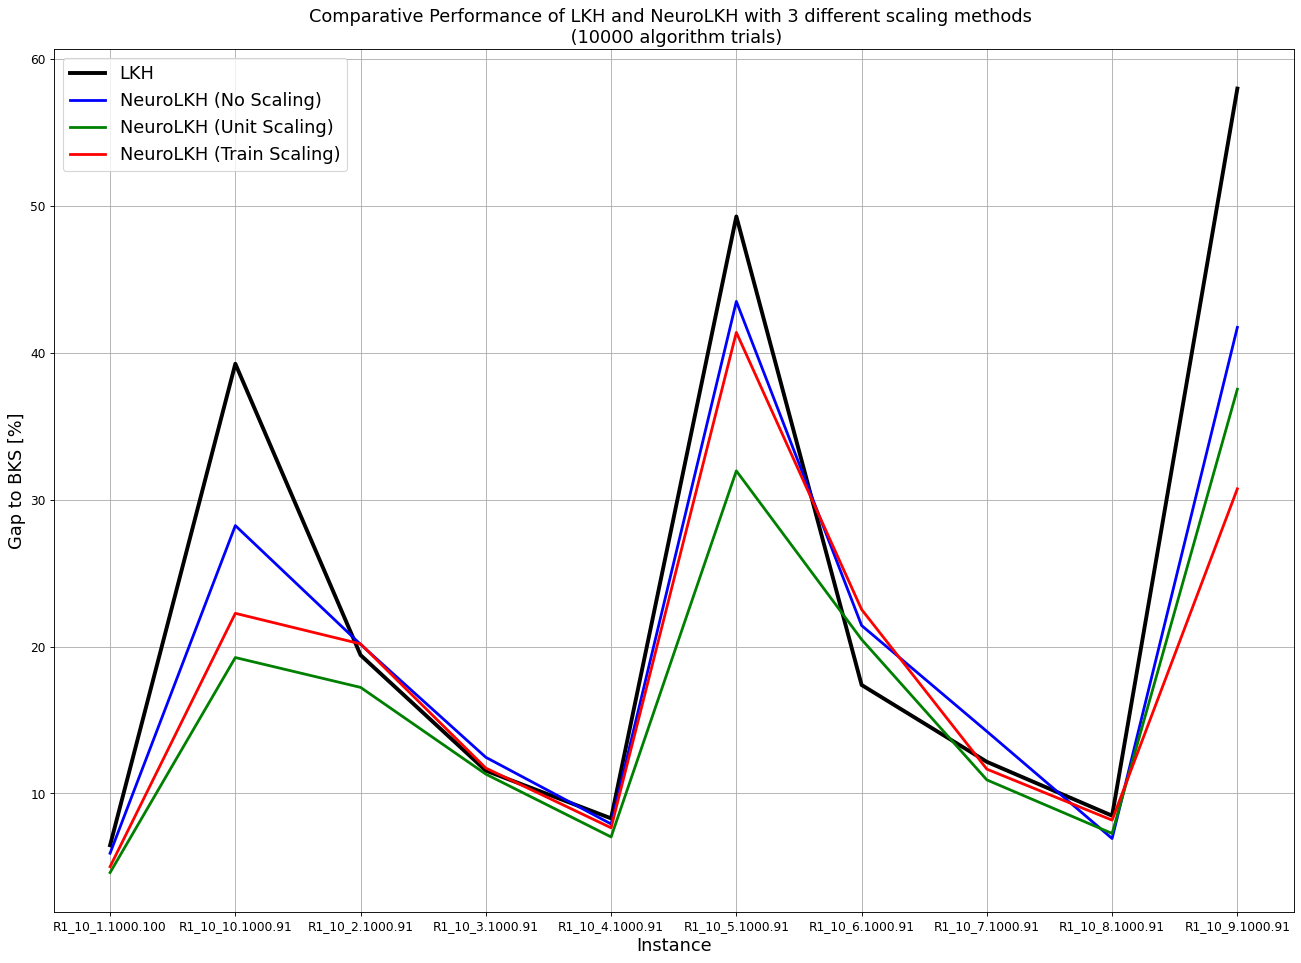

In [189]:

fig, ax = plt.subplots(figsize=(20,14),dpi=80)
ax.plot(name_var[0:10], gap_lkh[0:10],lw=3.5,color='k' ,label="LKH")
ax.plot(name_var[0:10], gap_nlkh_not[0:10],lw=2.5,color='b' , label="NeuroLKH (No Scaling)")
ax.plot(name_var[0:10], gap_nlkh_scaled[0:10],lw=2.5,color='g' , label="NeuroLKH (Unit Scaling)")
ax.plot(name_var[0:10], gap_nlkh_train_scaled[0:10],lw=2.5, color='r' ,label="NeuroLKH (Train Scaling)")

ax.legend(fontsize='16')
plt.rcParams['font.size'] = 11
plt.xlabel('Instance',fontsize = '16')
plt.ylabel('Gap to BKS [%]',fontsize = '16')
plt.title('Comparative Performance of LKH and NeuroLKH with 3 different scaling methods \n (10000 algorithm trials)',fontsize='16')
plt.grid(True)
#plt.savefig('GH_perf_R1_10_all.png')
plt.show()


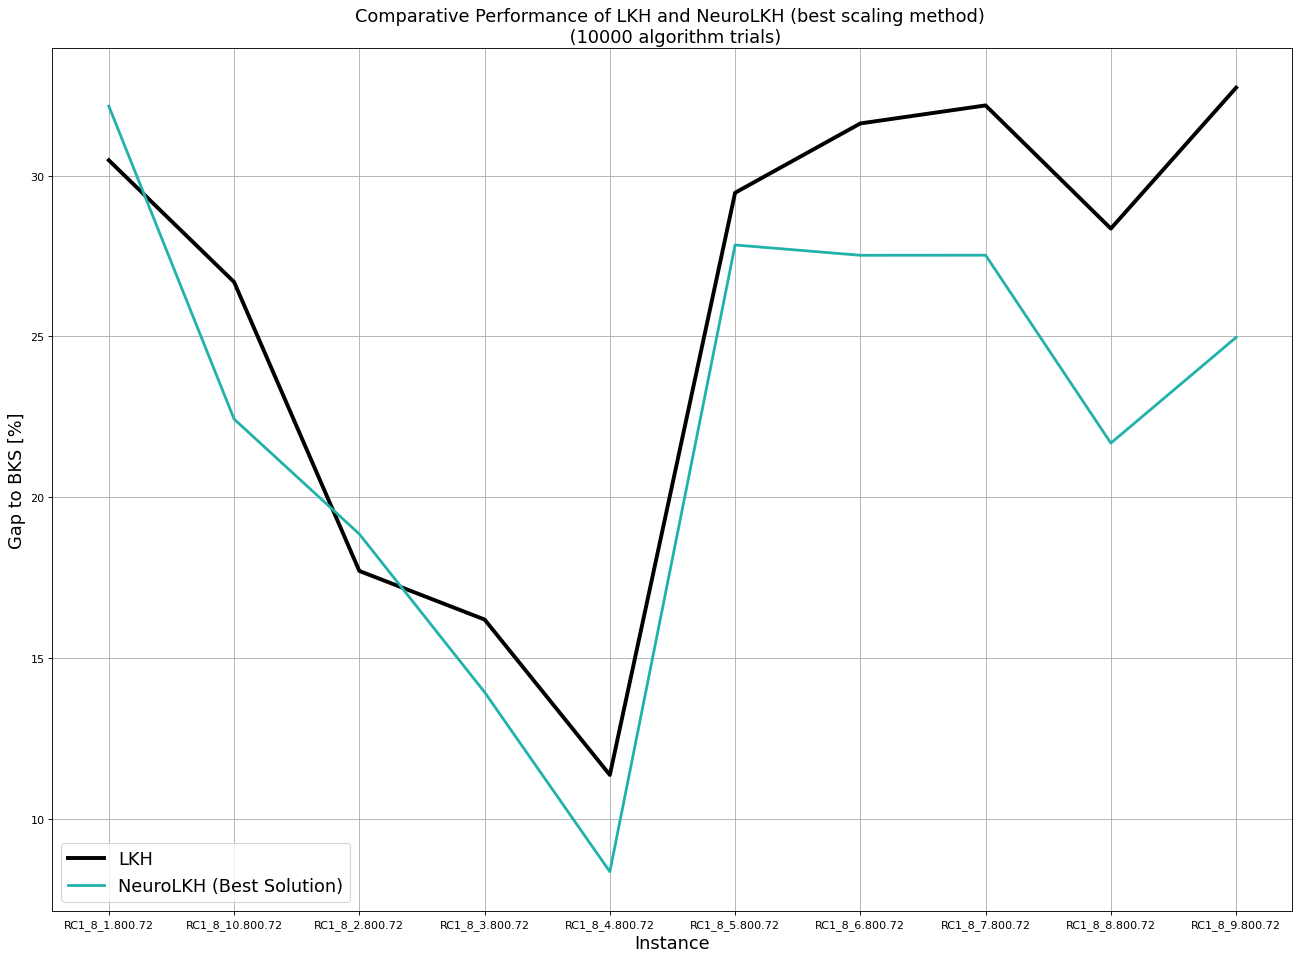

In [149]:
fig, ax = plt.subplots(figsize=(20,14),dpi=80)
ax.plot(name_var[90:100], gap_lkh[90:100],lw=3.5,color='k' ,label="LKH")
ax.plot(name_var[90:100], best_gap_nlkh[90:100],lw=2.5,color='lightseagreen' , label="NeuroLKH (Best Solution)")

ax.legend(fontsize='16')
plt.xlabel('Instance',fontsize = '16')
plt.ylabel('Gap to BKS [%]',fontsize = '16')
plt.title('Comparative Performance of LKH and NeuroLKH (best scaling method) \n (10000 algorithm trials)',fontsize='16')
plt.grid(True)
plt.savefig('GH_perf_RC1_8_best.png')
plt.show()


In [152]:
gap_to_lkh = - best_gap_nlkh + gap_lkh

In [ ]:
plt.figure(figsize=(10, 7), dpi=80)

plt.plot(mean_n_nlkh_time,mean_m_nlkh_obj*10e-7,lw=3.5,color='g',label = 'NeuroLKH')
plt.plot(mean_n_lkh_time,mean_m_lkh_obj*10e-7,lw=3.5,color='r',label = 'LKH')

# 
plt.xlabel('Running Time [s]',fontsize = '16')
plt.ylabel('Objective Function Value',fontsize = '16')
plt.title('Average performance of NeuroLKH and LKH for solving 100 instances of PDP500 \n (1000 LKH algorithm trials)',fontsize='16')
plt.legend()
plt.grid(True)
plt.show
#plt.savefig('PDP500_notscaled_long_perf_10000.png')

# Li & Lim Benchmark

In [19]:
NLKH_log_folder = "lilim_pdptw/NeuroLKH_log/*.log"
LKH_log_folder = "lilim_pdptw/LKH_log/*.log"

In [20]:
neuro_log_file = glob.glob(NLKH_log_folder)
lkh_log_file = glob.glob(LKH_log_folder)

In [28]:
lilim_df = pd.DataFrame(columns = ['Instance Name', 'BKS','LKH Solution',
                                     'LKH BKS Gap [%] ','LKH Solving Time [s] ','NeuroLKH Solution','NeuroLKH BKS Gap [%]','NeuroLKH Solving Time [s] ',
                                     'Gap Difference [%]','Solving Time Difference [s]','Time Ratio'])

In [29]:
ratio_time_var = [] 
diff_time_var = []
for i in range(len(neuro_log_file)):
    with open(neuro_log_file[i], 'r') as f:
        neuro_log_data = f.readlines()
    
    line_ = []
    for line in neuro_log_data:
        line = line.split()
        line_.append(line)
        
    while([] in line_):
        line_.remove([])
        
    with open(lkh_log_file[i], 'r') as f:
        lkh_log_data = f.readlines()
    
    line_lkh_ = []
    for line in lkh_log_data:
        line = line.split()
        line_lkh_.append(line)
    
    while([] in line_lkh_):
        line_lkh_.remove([])
    name = line_[0][-1][33:-5]
    bks = line_[35][-1]
    NeuroLKH_sol = line_[-11][-1]
    opt_gap_nlkh = line_[-10][-1][:-1]
    NeuroLKH_time = line_[-7][-2]
    LKH_sol = line_lkh_[-11][-1]
    opt_gap_lkh = line_lkh_[-10][-1][:-1]
    opt_gap_diff = str(round(float(opt_gap_lkh) - float(opt_gap_nlkh),2))
    LKH_time = line_lkh_[-7][-2]
    diff_time = str(round(float(LKH_time) - float(NeuroLKH_time),2))
    diff_time_var.append(round(float(LKH_time) - float(NeuroLKH_time),2))
    ratio_time = str(round(float(LKH_time)/float(NeuroLKH_time),2))
    ratio_time_var.append(round(float(LKH_time)/float(NeuroLKH_time),2))
    lilim_df = lilim_df.append({'Instance Name': name, 'BKS' : bks , 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
                               'NeuroLKH Solution' : NeuroLKH_sol , 'NeuroLKH BKS Gap [%]' : opt_gap_nlkh , 'NeuroLKH Solving Time [s] ' : NeuroLKH_time ,
                                     'Gap Difference [%]' : opt_gap_diff,'Solving Time Difference [s]' : diff_time, 'Time Ratio' : ratio_time}, ignore_index=True)


C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\2865429087.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lilim_df = lilim_df.append({'Instance Name': name, 'BKS' : bks , 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\2865429087.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lilim_df = lilim_df.append({'Instance Name': name, 'BKS' : bks , 'LKH Solution' : LKH_sol , 'LKH BKS Gap [%] ' : opt_gap_lkh , 'LKH Solving Time [s] ' : LKH_time ,
C:\Users\saqal\AppData\Local\Temp\ipykernel_3332\2865429087.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lilim_df = lilim_df.append({'Instance Name': name, 'BKS' : bks , '

In [31]:
lilim_df.to_csv('lilim_results.csv', index=False)
